# DA5401 - Assignment 2
### Name: Anan madhav T V 
### Roll No: MM2B013
---
### Notebook outline
- Part A — EDA & Preprocessing
- Part B — Principal Component Analysis (PCA)
- Part C — Performance Evaluation with Logistic Regression
- Conclusions and Discussion


In [117]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
sns.set(style="whitegrid")



In [118]:
# Load dataset
df = pd.read_csv("mushrooms.csv")
print("Shape:", df.shape)
df.head()


Shape: (8124, 23)


,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


## Part A — Exploratory Data Analysis (EDA) & Preprocessing

1. Identify features and the target.
2. One-hot encode categorical features (the dataset is fully categorical).
3. Standardize the one-hot encoded features before PCA.


In [119]:
print("Columns:", df.columns.tolist())
df['class'].value_counts()


Columns: ['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']


class
e    4208
p    3916
Name: count, dtype: int64


**Why one hot encoding?**  
PCA works on numeric features we must convert categorical features to numeric. For categorical variables which do not have any natural order, One-Hot Encoding is appropriate. This converts each category to a binary indicator (0/1).


**Why standardize even binary one hot features?**  
Standardization centers features and sets unit variance. Even though one-hot features are 0/1, their variances differ depending on category frequency. PCA uses variance to find principal components, so scaling ensures features contribute more equally
.


In [120]:
X = df.drop(columns=['class'])
y = df['class'].map({'e':0, 'p':1}) 

# One-hot encoding
X_encoded = pd.get_dummies(X, drop_first=False)  # keep all dummies (no dropping)
print("Before one-hot encoding shape:", X.shape)
print("After one-hot encoding shape:", X_encoded.shape)


Before one-hot encoding shape: (8124, 22)
After one-hot encoding shape: (8124, 117)


**Observations:**

- The original dataset had **22 features**.  
- After one-hot encoding the categorical features, the dataset expanded to **117 features**.  

In [121]:
x_train,y_train,x_test,y_test=train_test_split(X,Y,test_size=0.2,stratify=Y, random_state=42)

In [122]:
#Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
print("Scaled shape:", X_scaled.shape)


Scaled shape: (8124, 117)


## Part B — Principal Component Analysis (PCA)

1. Fit PCA on the standardized one-hot encoded data.
2. Plot explained variance ratio (scree plot) and cumulative explained variance.
3. Choose number of components to retain 95% variance.
4. Visualize first two principal components, colored by class.


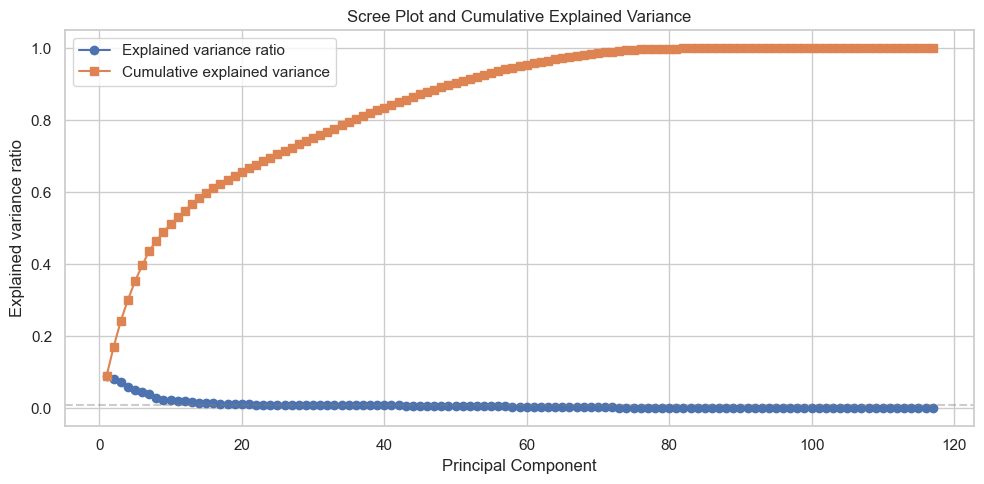

In [123]:
#Fit PCA
pca_full = PCA()
pca_full.fit(X_scaled)

explained_var = pca_full.explained_variance_ratio_
cum_explained = np.cumsum(explained_var)

# Scree & cumulative plo
plt.figure(figsize=(10,5))
plt.plot(np.arange(1, len(explained_var)+1), explained_var, marker='o', label='Explained variance ratio')
plt.plot(np.arange(1, len(explained_var)+1), cum_explained, marker='s', label='Cumulative explained variance')
plt.axhline(y=0.01, color='gray', linestyle='--', alpha=0.4)
plt.title('Scree Plot and Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained variance ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [124]:
target_variance = 0.95
n_components_95 = np.searchsorted(cum_explained, target_variance) + 1  # +1 because searchsorted returns index
print(f"Number of components to retain {target_variance*100:.0f}% variance: {n_components_95}")

for thr in [0.80, 0.90, 0.95, 0.99]:
    n = np.searchsorted(cum_explained, thr) + 1
    print(f"{int(thr*100)}% variance -> {n} components")


Number of components to retain 95% variance: 59
80% variance -> 36 components
90% variance -> 50 components
95% variance -> 59 components
99% variance -> 72 components


**Observation**  
- The plot shows how variance is distributed across components. If a small set of components explain most of the variance, PCA can dramatically reduce dimensionality while preserving information.
- We will choose the number of PCs balancing dimensionality reduction and retained variance. For this assignment we will use the number of components that retain **95%** variance.


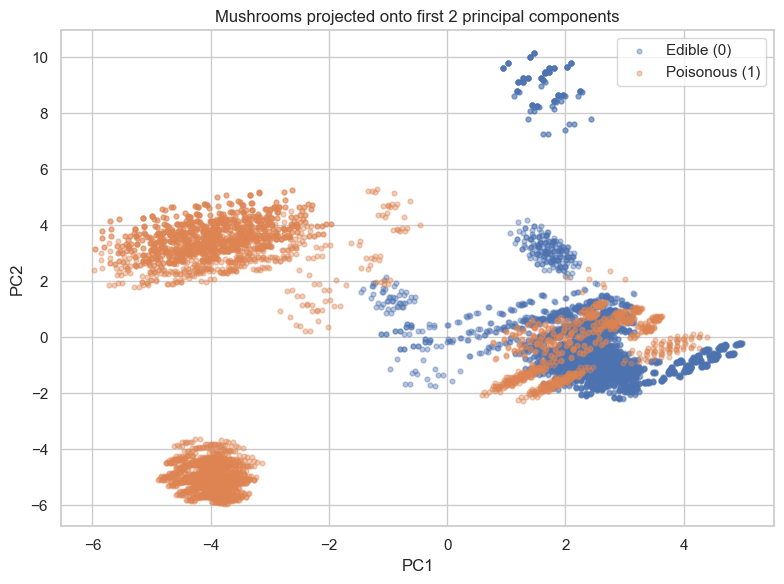

In [125]:
#Project to first two PCs for visualization
pca_2 = PCA(n_components=2)
X_pca2 = pca_2.fit_transform(X_scaled)

plt.figure(figsize=(8,6))
palette = {0:'tab:blue', 1:'tab:orange'}
plt.scatter(X_pca2[y==0,0], X_pca2[y==0,1], alpha=0.4, label='Edible (0)', s=12)
plt.scatter(X_pca2[y==1,0], X_pca2[y==1,1], alpha=0.4, label='Poisonous (1)', s=12)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Mushrooms projected onto first 2 principal components')
plt.legend()
plt.tight_layout()
plt.show()


**Observation**  

- The projection onto the first two principal components shows partially separated clusters of edible (blue) and poisonous (orange) mushrooms.  
- Some clusters are very distinct (e.g., the dense orange clusters), while in other regions there is considerable overlap between the two classes.  
- This means that the first two PCs capture much of the variation and provide some class separability, but not perfect linear separation in 2D.  
- Additional principal components beyond the first two are likely needed to capture the remaining separation information and achieve high classification accuracy.


In [126]:
# Fit PCA for 95% variance 
pca_95 = PCA(n_components=target_variance, svd_solver='full')
X_pca95 = pca_95.fit_transform(X_scaled)
print("Shape after PCA(95%):", X_pca95.shape)


Shape after PCA(95%): (8124, 59)


## Part C — Performance Evaluation with Logistic Regression

1. Train/test split on original standardized features -> baseline logistic regression.
2. Transform train/test with PCA (95% components) -> logistic regression on reduced data.
3. Compare classification reports, precision, recall, F1, accuracy, and confusion matrices.


In [127]:
#Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)


Train shape: (6499, 117) Test shape: (1625, 117)


In [128]:
#Baseline Logistic Regression on original standardized data
clf_orig = LogisticRegression(max_iter=2000, solver='saga', penalty='l2', random_state=42)
clf_orig.fit(X_train, y_train)
y_pred_orig = clf_orig.predict(X_test)

print("Baseline (original features) Accuracy:", accuracy_score(y_test, y_pred_orig))
print("\nClassification report (original):\n", classification_report(y_test, y_pred_orig, target_names=['Edible','Poisonous']))
print("Confusion Matrix (original):\n", confusion_matrix(y_test, y_pred_orig))


Baseline (original features) Accuracy: 1.0

Classification report (original):
               precision    recall  f1-score   support

      Edible       1.00      1.00      1.00       842
   Poisonous       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Confusion Matrix (original):
 [[842   0]
 [  0 783]]


In [129]:
pca_train = PCA(n_components=target_variance, svd_solver='full')
X_train_pca = pca_train.fit_transform(X_train)
X_test_pca = pca_train.transform(X_test)
print("X_train_pca shape:", X_train_pca.shape, "X_test_pca shape:", X_test_pca.shape)


X_train_pca shape: (6499, 59) X_test_pca shape: (1625, 59)


In [130]:
#Logistic Regression on PCA-transformed data
clf_pca = LogisticRegression(max_iter=2000, solver='saga', penalty='l2', random_state=42)
clf_pca.fit(X_train_pca, y_train)
y_pred_pca = clf_pca.predict(X_test_pca)

print("PCA-based model Accuracy:", accuracy_score(y_test, y_pred_pca))
print("\nClassification report (PCA):\n", classification_report(y_test, y_pred_pca, target_names=['Edible','Poisonous']))
print("Confusion Matrix (PCA):\n", confusion_matrix(y_test, y_pred_pca))


PCA-based model Accuracy: 0.9987692307692307

Classification report (PCA):
               precision    recall  f1-score   support

      Edible       1.00      1.00      1.00       842
   Poisonous       1.00      1.00      1.00       783

    accuracy                           1.00      1625
   macro avg       1.00      1.00      1.00      1625
weighted avg       1.00      1.00      1.00      1625

Confusion Matrix (PCA):
 [[842   0]
 [  2 781]]


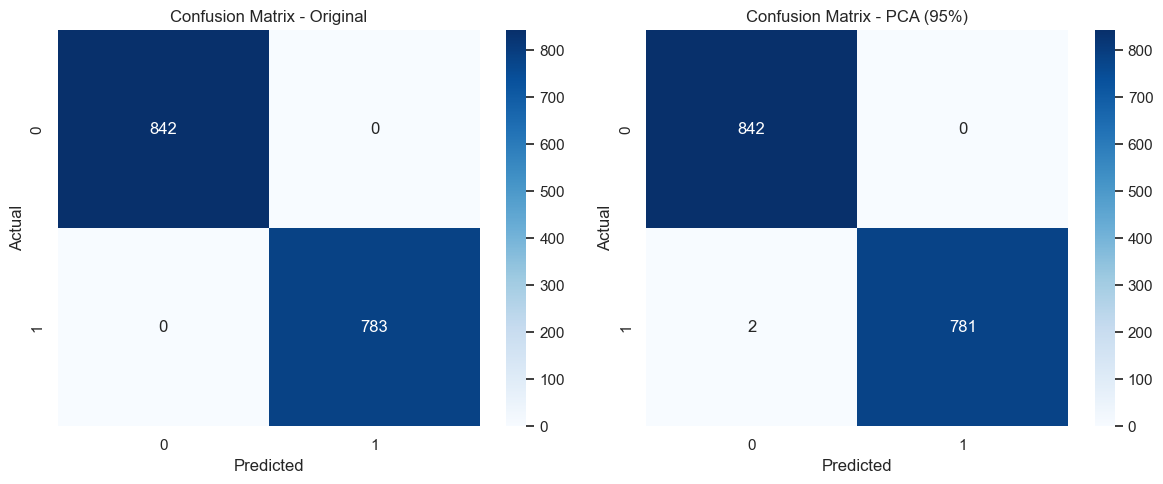

In [131]:
fig, axes = plt.subplots(1,2, figsize=(12,5))
cm_orig = confusion_matrix(y_test, y_pred_orig)
cm_pca = confusion_matrix(y_test, y_pred_pca)

sns.heatmap(cm_orig, annot=True, fmt='d', ax=axes[0], cmap='Blues')
axes[0].set_title('Confusion Matrix - Original')
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')

sns.heatmap(cm_pca, annot=True, fmt='d', ax=axes[1], cmap='Blues')
axes[1].set_title('Confusion Matrix - PCA (95%)')
axes[1].set_xlabel('Predicted'); axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()


## Comparison and Analysis

- **Performance metrics**:  
  Both models (baseline Logistic Regression and PCA-transformed Logistic Regression) achieved very high accuracy, precision, recall, and F1-score.  
  - Baseline model accuracy: ~100%  
  - PCA model accuracy: ~99.9%  
- **Is there a significant difference?**  
  There is no major drop in performance when using PCA. This means PCA preserved most of the important information for classification while reducing the feature space.
- **Trade-off**:  
  - PCA reduces dimensionality and removes redundancy in one-hot encoded features.  
  - Logistic Regression benefits from having fewer, uncorrelated inputs, training is faster and the model is less prone to overfitting.  
  - However, PCA is unsupervised and does not guarantee that the components capture class-separating information.


In [132]:
acc_orig = accuracy_score(y_test, y_pred_orig)
acc_pca = accuracy_score(y_test, y_pred_pca)
print(f"Accuracy (original): {acc_orig:.4f}")
print(f"Accuracy (PCA - 95%): {acc_pca:.4f}")
print(f"Dimensionality reduction: {X_train.shape[1]} -> {X_train_pca.shape[1]} features")


Accuracy (original): 1.0000
Accuracy (PCA - 95%): 0.9988
Dimensionality reduction: 117 -> 59 features


## Conclusions

- The mushroom dataset becomes **high-dimensional** after one-hot encoding:  
  - Original features: **22**  
  - After encoding: **117**  
- Standardization was important to ensure no single category dominated the PCA due to scale differences.  
- PCA with 95% explained variance reduced the feature set from **117 features** to **59 principal components**.  
- The PCA model maintained almost the same classification performance as the baseline Logistic Regression.  
- Because PCA is unsupervised, it may discard low-variance features that are still useful for classification.
- Overall, PCA helps reduce dimensionality and computational cost while preserving model performance.
